<a href="https://colab.research.google.com/github/Muntasir2179/pytorch-learnig/blob/computer-vision/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

## Computer vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision.
* `torchvision.datasets` - get dataset and data loading functions for computer vision here.
* `torchvision.models` - get pretrained computer vision models that can leverage for your won problems
* `torchvision.transform` - functions for manipulating vision data (images) to be suitable for use with ML models
* `torch.utils.data.Dataset` - Base dataset for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset.

In [1]:
# imporing pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib for visualzation
import matplotlib.pyplot as plt

# check the version
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


## Getting our data ready

### Downloading data

In [2]:
# setup training data
train_data = datasets.FashionMNIST(
    root='data', # where to download the data?
    train=True,  # do we want the training dataset?
    download=True,  # do we want to download?
    transform=torchvision.transforms.ToTensor(),  # how do we want to transform the data?
    target_transform=None  # how do we want to transform the labels/targets?
)

# setup testing data
test_data = datasets.FashionMNIST(
    root='data', # where to download the data?
    train=False,  # do we want the training dataset?
    download=True,  # do we want to download?
    transform=torchvision.transforms.ToTensor(),  # how do we want to transform the data?
    target_transform=None  # how do we want to transform the labels/targets?
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10660798.30it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171028.04it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3154775.30it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6006196.66it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# see the first training example
image  = train_data[0][0]
label = train_data[0][1]
class_names = train_data.classes
print(f"Shape of every image: {image.size()}")
print(f"Class number of the image: {class_names[label]}")

Shape of every image: torch.Size([1, 28, 28])
Class number of the image: Ankle boot


In [4]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### Visualizing our data

Image shape: torch.Size([1, 28, 28])


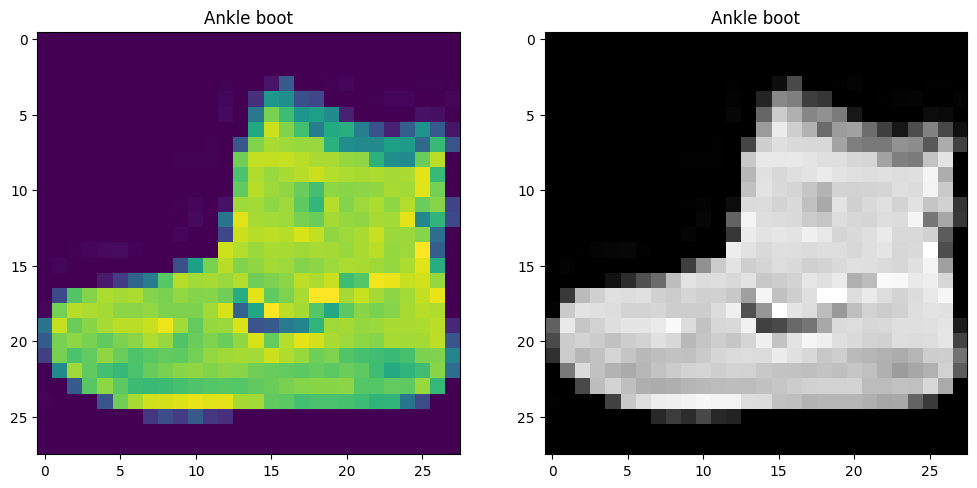

In [5]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(class_names[label])
plt.imshow(image.squeeze())

plt.subplot(1, 2, 2)
plt.title(class_names[label])
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

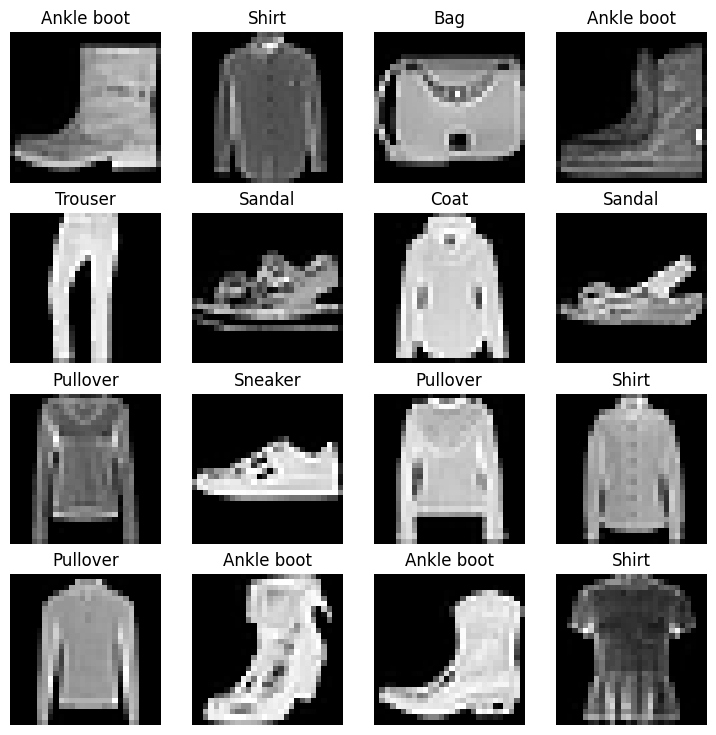

In [6]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)

### Prepare DataLoader
Right now the data in in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

🧮 Why we need to convert our data into minibatches?

1. It is computationalluy efficient, as in, your computing hardware may not be able to look (stire in memory) at 6000 images in one hit. So we break it down to 32 images at a time (batch size is 32).

2. It gives our neural netwoek more chances to update its gradients per epoch.

In [7]:
from torch.utils.data import DataLoader
# setup the batch size hyperparameter
BATCH_SIZE = 32

# turn dataset into iterable (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x787ac34350f0>,
 <torch.utils.data.dataloader.DataLoader at 0x787ac5ad5210>)

In [8]:
print(f"Length of the train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of the test_dataloader : {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of the train_dataloader: 1875 batches of 32
Length of the test_dataloader : 313 batches of 32


In [9]:
# check out what is inside the dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

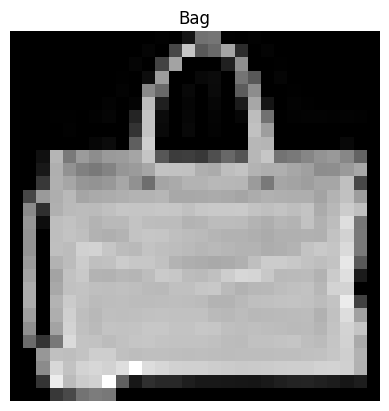

In [10]:
random_index = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_index], train_labels_batch[random_index]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
plt.show()

## Model-0: Building a model to fit our data (baseline model)

### Setting up device agnostic code

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Model building

In [12]:
# flatten layer
flatten_model = nn.Flatten()

# get a single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x)

print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [13]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

# setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=28*28, hidden_units=10, output_shape=len(class_names)).to('cpu')
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### Setting up loss funciton, optimizer and metrics

In [16]:
# getting helper function
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper_function.py already exists, skipping download...')
else:
  print('Downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

In [17]:
# imporing accuracy function
from helper_functions import accuracy_fn

# setting up loss funciton and optimizer
loss_fn = nn.CrossEntropyLoss()

# setting up optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [18]:
# creating a function to time our experiments
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
  """Prints difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [19]:
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')

Train time on cpu: 0.000 seconds


2.8810000003431924e-05

### Creating a training and testing loop

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the training loss per batch.
3. Loop through testing batch, perform testing steps, calculate the test loss per batch.
4. Print out what's happening.
5. Time it all (for fun).

In [20]:
# importing tqdm progress bar
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set the number of epochs (we will keep this small for faster training time)
epochs = 3

# create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----")
  # training
  train_loss = 0
  # add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # forward pass
    y_pred = model_0(X)

    # calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss  # accumulate train loss

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    # printing out what's happning
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # devide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  # testing loop
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # forward pass
      test_pred = model_0(X_test)

      # calculate the loss
      test_loss += loss_fn(test_pred, y_test)

      # calculate the accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # printing what's happening
  print(f"\nTraining loss: {train_loss: 0.4f} | Test loss: {test_loss: 0.4f} | Test acc: {test_acc: 0.4f}")

# calculate the trainng time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Training loss:  0.5904 | Test loss:  0.5095 | Test acc:  82.0387
Epoch: 1
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Training loss:  0.4763 | Test loss:  0.4799 | Test acc:  83.1969
Epoch: 2
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Training loss:  0.4550 | Test loss:  0.4766 | Test acc:  83.4265
Train time on cpu: 27.031 seconds


### Making predictions and getting results

In [21]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device='cpu'):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # puting data into target device
      X, y = X.to(device), y.to(device)

      # making predicitons
      y_pred = model(X)

      # accumulate the loss and accuracy values pre batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# calculate model_0 results on test dataset
model_0_resutls = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_resutls

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Model-1: Building a better model with non-linearity

In [22]:
# creating a model with non-linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),  # flatten inputs into a single vector
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

In [23]:
# creating a model_1 instance
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # this is the output of the flatten after our 28x28 image goes in
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Setting up loss function, optimizer and evaluation metric

In [24]:
from helper_functions import accuracy_fn

# defining loss function
loss_fn = nn.CrossEntropyLoss()

# setting up optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### Functionalizing training and evaluation/testing loops

* training loop - `train_step()`
* testing_loop - `test_step()`

In [25]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  # putting the model on training mode
  model.train()

  train_loss, train_acc = 0, 0
  # add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss  # accumulate train loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  #logits -> prediction labels

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

  # devide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss: .4f} | Train acc: {train_acc: 0.2f}%")


def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  """Performs a tesing loop step on model going over data_loader."""
  # testing loop
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # sending data to target device
      X, y = X.to(device), y.to(device)

      # forward pass
      test_pred = model(X)

      # calculate the loss and accuracy (per batch)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))  # logits -> prediction labels

    # calculate the test loss and accuracy average per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  # printing what's happening
  print(f"Test loss: {test_loss: 0.4f} | Test acc: {test_acc: 0.2f}%\n")

### Training model using `train_step()` and `test_step()` functions

In [26]:
torch.manual_seed(42)

from tqdm.auto import tqdm
from timeit import default_timer as timer

train_time_start_on_gpu = timer()

epochs = 3

# training model_1
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss:  1.0920 | Train acc:  61.34%
Test loss:  0.9564 | Test acc:  65.00%

Epoch: 1
------
Train loss:  0.7810 | Train acc:  71.93%
Test loss:  0.7223 | Test acc:  73.91%

Epoch: 2
------
Train loss:  0.6703 | Train acc:  75.94%
Test loss:  0.6850 | Test acc:  75.02%

Train time on cuda: 31.606 seconds


**🧮Note:** Sometimes, depending on the data/hardware it can happen that the model is performing faster on CPU than GPU.

> Why is this?
>
>Ans: It could be that the overhead for copying data/model to and form the GPU outweights the compute benefits offered by the GPU.

In [27]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

## Model-2: Building a Convolutional Neural Network (CNN)

CNN's are also known ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

Resources: [https://poloclub.github.io/cnn-explainer/](https://poloclub.github.io/cnn-explainer/)

### Model building

In [28]:
# Creating a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [29]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

In [30]:
random_image_tensor = torch.randn(size=(1, 28, 28))
random_image_tensor.shape

torch.Size([1, 28, 28])

In [32]:
model_2(random_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Training the CNN model

In [33]:
from helper_functions import accuracy_fn
# setting up loss function
loss_fn = nn.CrossEntropyLoss()

# setting up optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [34]:
# training and testing our CNN model
torch.manual_seed(42)

# measure the time
train_time_start_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_cpu = timer()
total_train_time = print_train_time(start=train_time_start_cpu,
                                    end=train_time_end_cpu,
                                    device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss:  0.5925 | Train acc:  78.38%
Test loss:  0.3923 | Test acc:  85.87%

Epoch: 1
-------
Train loss:  0.3618 | Train acc:  86.85%
Test loss:  0.3625 | Test acc:  86.80%

Epoch: 2
-------
Train loss:  0.3243 | Train acc:  88.29%
Test loss:  0.3384 | Test acc:  87.67%

Train time on cuda: 34.631 seconds


In [35]:
# get model_2 results
model_2_result = eval_model(model=model_2,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)
model_2_result

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33843424916267395,
 'model_acc': 87.66972843450479}

### Stepping through `nn.Conv2d()`

In [36]:
torch.manual_seed(42)

# create a batch of images
images = torch.rand(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {image.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([1, 28, 28])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[0.8823, 0.9150, 0.3829,  ..., 0.1587, 0.6542, 0.3278],
         [0.6532, 0.3958, 0.9147,  ..., 0.2083, 0.3289, 0.1054],
         [0.9192, 0.4008, 0.9302,  ..., 0.5535, 0.4117, 0.3510],
         ...,
         [0.1457, 0.1499, 0.3298,  ..., 0.9624, 0.6400, 0.7409],
         [0.1709, 0.5797, 0.6340,  ..., 0.6885, 0.2405, 0.5956],
         [0.9199, 0.1247, 0.3573,  ..., 0.6752, 0.2058, 0.5027]],

        [[0.1458, 0.9024, 0.9217,  ..., 0.1868, 0.6352, 0.8431],
         [0.9549, 0.4435, 0.6924,  ..., 0.1168, 0.7160, 0.5462],
         [0.1616, 0.1054, 0.8614,  ..., 0.4531, 0.4736, 0.9448],
         ...,
         [0.4309, 0.3986, 0.1907,  ..., 0.9444, 0.2848, 0.3776],
         [0.7948, 0.6855, 0.1009,  ..., 0.6147, 0.7747, 0.2323],
         [0.5840, 0.9795, 0.3277,  ..., 0.3549, 0.1263, 0.1280]],

        [[0.5027, 0.4195, 0.8893,  ..., 0.3084, 0.1567, 0.7860],
         [0.7310, 0.930

In [37]:
# a single Conv2D layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3,3), stride=1, padding=1)
conv_output = conv_layer(test_image)

# convolution operation has changed the shape of the image
test_image.shape, conv_output.shape

(torch.Size([3, 64, 64]), torch.Size([10, 64, 64]))

### Stepping through `nn.MaxPool2d()`

In [38]:
test_image.shape

torch.Size([3, 64, 64])

In [39]:
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# creating a maxpool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# pass data through the max_pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 64, 64])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 32, 32])


In [40]:
torch.manual_seed(42)
# create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1 , 1, 2, 2))
print(f"Random tensor:\n {random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# creating a maxpool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax Pool tensor: {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")
random_tensor

Random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max Pool tensor: tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

## Comparing our models resutls

In [41]:
import pandas as pd
models_result = pd.DataFrame([model_0_resutls,
                              model_1_results,
                              model_2_result])
models_result

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.338434,87.669728


In [42]:
# adding training time to models_result
models_result['training_time'] = [total_train_time_model_0,
                                  total_train_time_model_1,
                                  total_train_time]
models_result

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,27.031462
1,FashionMNISTModelV1,0.685001,75.019968,31.605562
2,FashionMNISTModelV2,0.338434,87.669728,34.630836


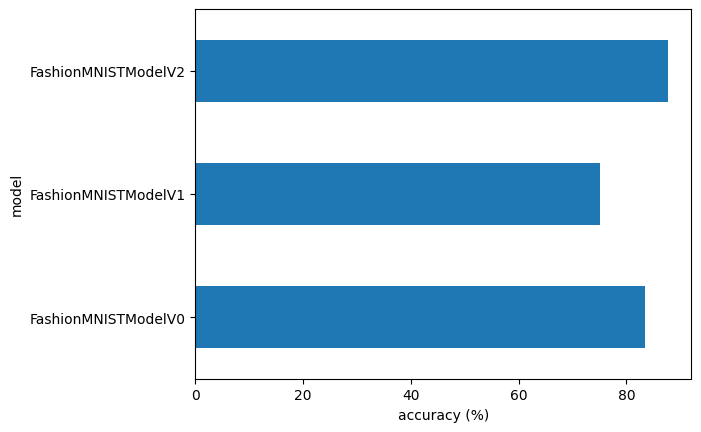

In [44]:
# visualize our models result
models_result.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")
plt.show()